本项目使用Python语言对银行个人金融数据进行分析，以对个人贷款用户会否违约进行预测。

本文目录：

1 导入数据

2 数据整理

3 逻辑回归建模预测

参考



1 导入数据

本项目数据集来自天山学院[《数据科学实战：Python篇（案例：个人贷款违约预测模型）》](https://link.zhihu.com/?target=https%3A//edu.hellobi.com/course/270)课程的老师Ben，非常感谢Ben老师的分享和课程讲解。

本数据集包含账户表accounts、信用卡表card、客户信息表clients、权限分配表disp、人口地区统计表district、贷款表loans、支付命令表order和交易表trans。

1.1 导入基础库

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('./案例')
os.getcwd()

'/home/jovyan/Pandas/案例'

1.2 导入数据

In [9]:
loanfile=os.listdir()
createVar=locals()
for i in loanfile:
    if i.endswith('csv'):
        createVar[i.split('.')[0]]=pd.read_csv(i,encoding='gbk')
        print(i.split('.')[0])

card
accounts
clients
RFM_TRAD_FLOW
disp
district
order
trans
loans


2 数据整理

2.1 生成被解释变量

In [10]:
loans.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033,B
1,5316,1801,1993-07-11,165960,36,4610,A
2,6863,9188,1993-07-28,127080,60,2118,A
3,5325,1843,1993-08-03,105804,36,2939,A
4,7240,11013,1993-09-06,274740,60,4579,A


查看贷款表的描述信息

In [11]:
loans.describe()

,loan_id,account_id,amount,duration,payments
count,682.000000,682.000000,682.000000,682.000000,682.000000
mean,6172.466276,5824.162757,151410.175953,36.492669,4190.664223
std,682.579279,3283.512681,113372.406310,17.075219,2215.830344
min,4959.000000,2.000000,4980.000000,12.000000,304.000000
25%,5577.500000,2967.000000,66732.000000,24.000000,2477.000000
50%,6176.500000,5738.500000,116928.000000,36.000000,3934.000000
75%,6752.500000,8686.000000,210654.000000,48.000000,5813.500000
max,7308.000000,11362.000000,590820.000000,60.000000,9910.000000


查看贷款表中还款状态信息，并利用字典生成被解释变量

In [12]:
loans.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [13]:
bad_good={'A':0,'B':1,'D':1,'C':2}
loans['bad_good']=loans.status.map(bad_good)
loans.head()

,loan_id,account_id,date,amount,duration,payments,status,bad_good
0,5314,1787,1993-07-05,96396,12,8033,B,1
1,5316,1801,1993-07-11,165960,36,4610,A,0
2,6863,9188,1993-07-28,127080,60,2118,A,0
3,5325,1843,1993-08-03,105804,36,2939,A,0
4,7240,11013,1993-09-06,274740,60,4579,A,0


2.2 数据合并

In [15]:
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,所有者
1,2,2,2,所有者
2,3,3,2,用户
3,4,4,3,所有者
4,5,5,3,用户


查看客户信息表

In [16]:
clients.head()

,client_id,sex,birth_date,district_id
0,1,女,1970-12-13,18
1,2,男,1945-02-04,1
2,3,女,1940-10-09,1
3,4,男,1956-12-01,5
4,5,女,1960-07-03,5


In [17]:
data2=pd.merge(loans,disp,on='account_id',how='left')
data2=pd.merge(data2,clients,on='client_id',how='left')
data2.head()

,loan_id,account_id,date,amount,duration,payments,status,bad_good,disp_id,client_id,type,sex,birth_date,district_id
0,5314,1787,1993-07-05,96396,12,8033,B,1,2166,2166,所有者,女,1947-07-22,30
1,5316,1801,1993-07-11,165960,36,4610,A,0,2181,2181,所有者,男,1968-07-22,46
2,6863,9188,1993-07-28,127080,60,2118,A,0,11006,11314,所有者,男,1936-06-02,45
3,5325,1843,1993-08-03,105804,36,2939,A,0,2235,2235,所有者,女,1940-04-20,14
4,7240,11013,1993-09-06,274740,60,4579,A,0,13231,13539,所有者,男,1978-09-07,63


In [18]:
district.head()

,A1,GDP,A4,A10,A11,A12,A13,A14,A15,a16
0,1,283894,1204953,100.0,12541,0.29,0.43,167,35.6,41.1
1,2,11655,88884,46.7,8507,1.67,1.85,132,12.1,15.0
2,3,13146,75232,41.7,8980,1.95,2.21,111,18.8,18.7
3,4,16108,149893,67.4,9753,4.64,5.05,109,17.5,19.7
4,5,13452,95616,51.4,9307,3.85,4.43,118,13.7,15.9


In [19]:
data3=pd.merge(data2,district,left_on='district_id',right_on='A1',how='left')
data3.head()

,loan_id,account_id,date,amount,duration,payments,status,bad_good,disp_id,client_id,...,A1,GDP,A4,A10,A11,A12,A13,A14,A15,a16
0,5314,1787,1993-07-05,96396,12,8033,B,1,2166,2166,...,30,16979,94812,81.8,9650,3.38,3.67,100,15.7,14.8
1,5316,1801,1993-07-11,165960,36,4610,A,0,2181,2181,...,46,14111,112709,73.5,8369,1.79,2.31,117,12.7,11.6
2,6863,9188,1993-07-28,127080,60,2118,A,0,11006,11314,...,45,12888,77917,53.5,8390,2.28,2.89,132,13.3,13.6
3,5325,1843,1993-08-03,105804,36,2939,A,0,2235,2235,...,14,31891,177686,74.8,10045,1.42,1.71,135,18.6,17.7
4,7240,11013,1993-09-06,274740,60,4579,A,0,13231,13539,...,63,11322,86513,50.5,8288,3.79,4.52,110,9.0,8.4


In [20]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,贷,信贷资金,$700,$700,NaN,NaN,NaN
1,171812,576,1993-01-01,贷,信贷资金,$900,$900,NaN,NaN,NaN
2,207264,704,1993-01-01,贷,信贷资金,"$1,000","$1,000",NaN,NaN,NaN
3,1117247,3818,1993-01-01,贷,信贷资金,$600,$600,NaN,NaN,NaN
4,579373,1972,1993-01-02,贷,信贷资金,$400,$400,NaN,NaN,NaN


In [21]:
data4_t1=pd.merge(data3[['account_id','date']],trans[['account_id','type','amount','balance','date']],on='account_id')
data4_t1.columns=['account_id','date','type','amount','balance','t_date']
data4_t1.head(10)

,account_id,date,type,amount,balance,t_date
0,1787,1993-07-05,贷,"$1,100","$1,100",1993-03-22
1,1787,1993-07-05,贷,"$9,900",$11000,1993-04-21
2,1787,1993-07-05,贷,"$5,800",$16800,1993-05-21
3,1787,1993-07-05,贷,"$3,300",$20100,1993-06-20
4,1787,1993-07-05,贷,$42248,$62348,1993-07-08
5,1787,1993-07-05,借,$16600,$45748,1993-07-20
6,1787,1993-07-05,贷,$74,$45822,1993-07-31
7,1787,1993-07-05,借,$12400,$33422,1993-08-19
8,1787,1993-07-05,贷,$191,$33612,1993-08-31
9,1787,1993-07-05,借,"$3,300",$30312,1993-09-18


In [22]:
data4_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233627 entries, 0 to 233626
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   account_id  233627 non-null  int64 
 1   date        233627 non-null  object
 2   type        233627 non-null  object
 3   amount      233627 non-null  object
 4   balance     233627 non-null  object
 5   t_date      233627 non-null  object
dtypes: int64(1), object(5)
memory usage: 12.5+ MB


数据转换：将data4_t1的date和t_date列数据类型转换为时间类型

In [23]:
data4_t1.date=pd.to_datetime(data4_t1.date)
data4_t1.t_date=pd.to_datetime(data4_t1.t_date)
data4_t1=data4_t1.sort_values(by=['account_id','t_date'])
data4_t1.tail()

,account_id,date,type,amount,balance,t_date
156327,11362,1996-12-27,借,$56,$51420,1998-12-08
156328,11362,1996-12-27,借,"$4,780",$46640,1998-12-10
156329,11362,1996-12-27,借,"$5,392",$41248,1998-12-12
156330,11362,1996-12-27,借,"$2,880",$38368,1998-12-19
156331,11362,1996-12-27,贷,$163,$38531,1998-12-31


数据转换：将data4_t1的amount和balance列数据类型转换为数值类型

In [24]:
data4_t1['amount2']=data4_t1.amount.map(lambda x : int(''.join(x[1:].split(','))))
data4_t1['balance2']=data4_t1.balance.map(lambda x : int(''.join(x[1:].split(','))))
data4_t1.head()

,account_id,date,type,amount,balance,t_date,amount2,balance2
11182,2,1994-01-05,贷,"$1,100","$1,100",1993-02-26,1100,1100
11660,2,1994-01-05,贷,"$1,100","$1,100",1993-02-26,1100,1100
11183,2,1994-01-05,贷,$20236,$21336,1993-03-12,20236,21336
11661,2,1994-01-05,贷,$20236,$21336,1993-03-12,20236,21336
11184,2,1994-01-05,贷,"$3,700",$25036,1993-03-28,3700,25036


In [25]:
data4_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233627 entries, 11182 to 156331
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   account_id  233627 non-null  int64         
 1   date        233627 non-null  datetime64[ns]
 2   type        233627 non-null  object        
 3   amount      233627 non-null  object        
 4   balance     233627 non-null  object        
 5   t_date      233627 non-null  datetime64[ns]
 6   amount2     233627 non-null  int64         
 7   balance2    233627 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 16.0+ MB


将交易数据的时间窗口设置为贷款前一年期间

In [26]:
import datetime
data4_t2=data4_t1[(data4_t1.date>data4_t1.t_date)&(data4_t1.date<data4_t1.t_date+datetime.timedelta(days=365))]
data4_t2.tail()

,account_id,date,type,amount,balance,t_date,amount2,balance2
156090,11362,1996-12-27,借,$129,$39766,1996-12-06,129,39766
156091,11362,1996-12-27,借,$10400,$29366,1996-12-07,10400,29366
156092,11362,1996-12-27,借,$330,$29036,1996-12-07,330,29036
156093,11362,1996-12-27,借,$56,$28980,1996-12-08,56,28980
156094,11362,1996-12-27,借,"$4,780",$24200,1996-12-10,4780,24200


计算账户的平均余额、余额的标准差、变异系数

In [27]:
data4_t3=data4_t2.groupby('account_id')['balance2'].agg([('avg_balance','mean'),('std_balance','std')])
data4_t3['cv_balance']=data4_t3[['avg_balance','std_balance']].apply(lambda x :x[1]/x[0],axis=1)
data4_t3.head(10)

,avg_balance,std_balance,cv_balance
account_id,,,
2,32590.759259,12005.306334,0.368365
19,25871.223684,15057.521648,0.582018
25,56916.984496,21058.667949,0.369989
37,36658.981308,20782.996690,0.566928
38,31383.581818,10950.723180,0.348932
67,50038.278351,19673.106899,0.393161
97,32870.592593,12055.401779,0.366753
103,46666.109589,27699.868290,0.593576
105,30702.152174,15745.147712,0.512835


计算平均支出与平均收入的比例

In [28]:
type_dict={'借':'out','贷':'income'}
data4_t2['type2']=data4_t2.type.map(type_dict)
data4_t4=data4_t2.groupby(['account_id','type2'])[['amount2']].sum()
data4_t4.head(10)

<ipython-input-28-066f2a86fba4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4_t2['type2']=data4_t2.type.map(type_dict)


amount2
account_id type2          
2          income   553028
           out      306040
19         income   254255
           out      198020
25         income   726479
           out      629108
37         income   386357
           out      328541
38         income   154300
           out      105091

In [29]:
data4_t5=pd.pivot_table(data4_t4,values='amount2',index='account_id',columns='type2')
data4_t5.fillna(0,inplace=True)
data4_t5['r_out_in']=data4_t5[['out','income']].apply(lambda x :x[0]/x[1],axis=1)
data4_t5.head(10)

type2,income,out,r_out_in
account_id,,,
2,553028.0,306040.0,0.553390
19,254255.0,198020.0,0.778824
25,726479.0,629108.0,0.865969
37,386357.0,328541.0,0.850356
38,154300.0,105091.0,0.681082
67,580693.0,524336.0,0.902949
97,474980.0,478288.0,1.006965
103,434901.0,243539.0,0.559987
105,192522.0,193505.0,1.005106


In [30]:
data4=pd.merge(data3,data4_t3,left_on='account_id',right_index=True,how='left')
data4=pd.merge(data4,data4_t5,left_on='account_id',right_index=True,how='left')
data4.head(10)

,loan_id,account_id,date,amount,duration,payments,status,bad_good,disp_id,client_id,...,A13,A14,A15,a16,avg_balance,std_balance,cv_balance,income,out,r_out_in
0,5314,1787,1993-07-05,96396,12,8033,B,1,2166,2166,...,3.67,100,15.7,14.8,12250.000000,8330.866301,0.680071,20100.0,0.0,0.000000
1,5316,1801,1993-07-11,165960,36,4610,A,0,2181,2181,...,2.31,117,12.7,11.6,43975.810811,25468.748605,0.579154,243576.0,164004.0,0.673318
2,6863,9188,1993-07-28,127080,60,2118,A,0,11006,11314,...,2.89,132,13.3,13.6,30061.041667,11520.127013,0.383224,75146.0,54873.0,0.730219
3,5325,1843,1993-08-03,105804,36,2939,A,0,2235,2235,...,1.71,135,18.6,17.7,41297.640000,14151.357776,0.342667,120310.0,86018.0,0.714970
4,7240,11013,1993-09-06,274740,60,4579,A,0,13231,13539,...,4.52,110,9.0,8.4,49780.777778,22172.541600,0.445404,276327.0,235214.0,0.851216
5,6687,8261,1993-09-13,87840,24,3660,A,0,9892,10200,...,3.26,123,14.8,17.4,46318.647059,20355.375622,0.439464,205294.0,117600.0,0.572837
6,6687,8261,1993-09-13,87840,24,3660,A,0,9893,10201,...,3.26,123,14.8,17.4,46318.647059,20355.375622,0.439464,205294.0,117600.0,0.572837
7,7284,11265,1993-09-15,52788,12,4399,A,0,13537,13845,...,3.60,124,15.7,16.0,22198.162791,6652.641641,0.299693,90384.0,69357.0,0.767359
8,6111,5428,1993-09-24,174744,24,7281,B,1,6551,6551,...,2.01,128,21.2,21.5,31235.531250,22996.709375,0.736236,226210.0,143645.0,0.635007
9,7235,10973,1993-10-13,154416,48,3217,A,0,13182,13490,...,3.35,131,12.3,13.5,46716.156250,20287.004574,0.434261,209665.0,102020.0,0.486586


计算贷存比和贷收比

In [31]:
data4['r_lb']=data4[['amount','avg_balance']].apply(lambda x : x[0]/x[1],axis=1)
data4['r_lin']=data4[['amount','income']].apply(lambda x : x[0]/x[1],axis=1)
data4.head()

,loan_id,account_id,date,amount,duration,payments,status,bad_good,disp_id,client_id,...,A15,a16,avg_balance,std_balance,cv_balance,income,out,r_out_in,r_lb,r_lin
0,5314,1787,1993-07-05,96396,12,8033,B,1,2166,2166,...,15.7,14.8,12250.000000,8330.866301,0.680071,20100.0,0.0,0.000000,7.869061,4.795821
1,5316,1801,1993-07-11,165960,36,4610,A,0,2181,2181,...,12.7,11.6,43975.810811,25468.748605,0.579154,243576.0,164004.0,0.673318,3.773893,0.681348
2,6863,9188,1993-07-28,127080,60,2118,A,0,11006,11314,...,13.3,13.6,30061.041667,11520.127013,0.383224,75146.0,54873.0,0.730219,4.227398,1.691108
3,5325,1843,1993-08-03,105804,36,2939,A,0,2235,2235,...,18.6,17.7,41297.640000,14151.357776,0.342667,120310.0,86018.0,0.714970,2.561987,0.879428
4,7240,11013,1993-09-06,274740,60,4579,A,0,13231,13539,...,9.0,8.4,49780.777778,22172.541600,0.445404,276327.0,235214.0,0.851216,5.518998,0.994257


选取权限类型是“所有者”的行，去除掉权限类型是“用户”的行，因只有“所有者”类型才具有贷款权限。

In [32]:
data4=data4[data4.type=='所有者']
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 826
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loan_id      682 non-null    int64  
 1   account_id   682 non-null    int64  
 2   date         682 non-null    object 
 3   amount       682 non-null    int64  
 4   duration     682 non-null    int64  
 5   payments     682 non-null    int64  
 6   status       682 non-null    object 
 7   bad_good     682 non-null    int64  
 8   disp_id      682 non-null    int64  
 9   client_id    682 non-null    int64  
 10  type         682 non-null    object 
 11  sex          682 non-null    object 
 12  birth_date   682 non-null    object 
 13  district_id  682 non-null    int64  
 14  A1           682 non-null    int64  
 15  GDP          682 non-null    int64  
 16  A4           682 non-null    int64  
 17  A10          682 non-null    float64
 18  A11          682 non-null    int64  
 19  A12     

3 逻辑回归建模预测

3.1 提取相关数据

In [34]:
data4.columns

Index(['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments',
       'status', 'bad_good', 'disp_id', 'client_id', 'type', 'sex',
       'birth_date', 'district_id', 'A1', 'GDP', 'A4', 'A10', 'A11', 'A12',
       'A13', 'A14', 'A15', 'a16', 'avg_balance', 'std_balance', 'cv_balance',
       'income', 'out', 'r_out_in', 'r_lb', 'r_lin'],
      dtype='object')

In [35]:
data_model=data4[data4['status']!='C']
for_predict=data4[data4['status']=='C']
train=data_model.sample(frac=0.7,random_state=1235).copy()
test=data_model[~data_model.index.isin(train.index)].copy()
print('训练样本量：%i \n测试样本量：%i' %(len(train),len(test)))
len(data_model),len(for_predict),len(data4)

训练样本量：195 
测试样本量：84


(279, 403, 682)

3.2 建模

In [37]:
def forward_select(data, response):
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            aic = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(sm.families.links.logit)
            ).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score > best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('aic is {},continuing!'.format(current_score))
        else:        
            print ('forward selection over!')
            break

    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = smf.glm(
        formula=formula, data=data, 
        family=sm.families.Binomial(sm.families.links.logit)
    ).fit()
    return(model)


candidates = ['bad_good', 'A1', 'GDP', 'A4', 'A10', 'A11', 'A12','amount', 'duration',
       'A13', 'A14', 'A15', 'a16', 'avg_balance', 'std_balance',
       'cv_balance', 'income', 'out', 'r_out_in', 'r_lb', 'r_lin']
data_for_select =train[candidates]
lg_m1=forward_select(data=data_for_select,response='bad_good')
lg_m1.summary().tables[1]


<ipython-input-37-f2cb01bac16e>:15: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  family=sm.families.Binomial(sm.families.links.logit)


aic is 167.4331143250464,continuing!
aic is 135.49278268705092,continuing!
aic is 133.50978045995745,continuing!
forward selection over!
final formula is bad_good ~ r_lb + cv_balance + income 


<ipython-input-37-f2cb01bac16e>:33: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  family=sm.families.Binomial(sm.families.links.logit)


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-6.8746,1.159,-5.933,0.000,-9.146,-4.604
r_lb,0.4157,0.096,4.330,0.000,0.228,0.604
cv_balance,10.6251,2.172,4.891,0.000,6.368,14.883
income,-1.812e-06,9.73e-07,-1.862,0.063,-3.72e-06,9.51e-08


3.3 用测试集对模型进行评估

Text(0.5, 1.0, 'ROC curve')

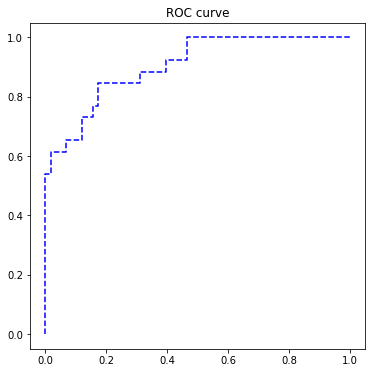

In [39]:
import sklearn.metrics as metrics
fpr,tpr,th=metrics.roc_curve(test.bad_good,lg_m1.predict(test))
plt.figure(figsize=[6,6])
plt.plot(fpr,tpr,'b--')
plt.title('ROC curve')

In [40]:
print('AUC=%.4f' %metrics.auc(fpr,tpr))

AUC=0.9045


3.4 预测

In [41]:
for_predict['prob']=lg_m1.predict(for_predict)
for_predict[['account_id','prob']].head(10)

<ipython-input-41-56e99efe978e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_predict['prob']=lg_m1.predict(for_predict)


,account_id,prob
27,1071,0.727744
36,5313,0.850604
47,10079,0.024767
49,5385,0.223669
52,8321,0.025317
56,2933,0.371913
76,8558,0.876097
78,1811,0.358063
80,4260,0.416784
87,2824,0.024844


参考：

1、[天善学院《数据科学实战：Python篇（案例：个人贷款违约预测模型）》by Ben](https://link.zhihu.com/?target=https%3A//edu.hellobi.com/course/270)

2、《利用Python进行数据分析》机械工业出版社 Wes Mckinney著 唐雪韬等译

3、[kaggle《Give Me Some Credit!》 by meet_your_maker](https://link.zhihu.com/?target=https%3A//www.kaggle.com/leafar/give-me-some-credit)